In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap

from src.maze_generator import get_maze_mdp
from src.policies import EpsGreedyPolicy, SoftmaxPolicy
from src.learning import QLearning
from src.utils import get_one_episode, viz_path, plot_maze_q_star, plot_path_q, plot_errors

In [3]:
SEED = 0
np.random.seed(SEED)

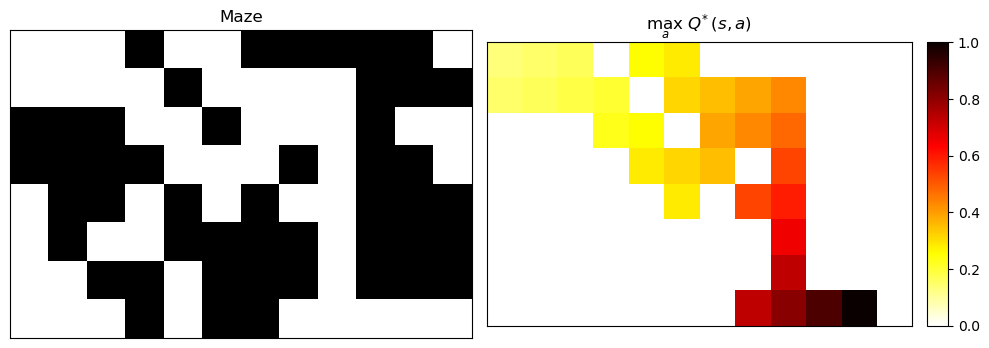

In [4]:
small_mdp, small_grid, small_q = get_maze_mdp(nrows=8, ncols=12, p=.5, gamma=.9, seed=SEED)
plot_maze_q_star(small_grid, small_q)

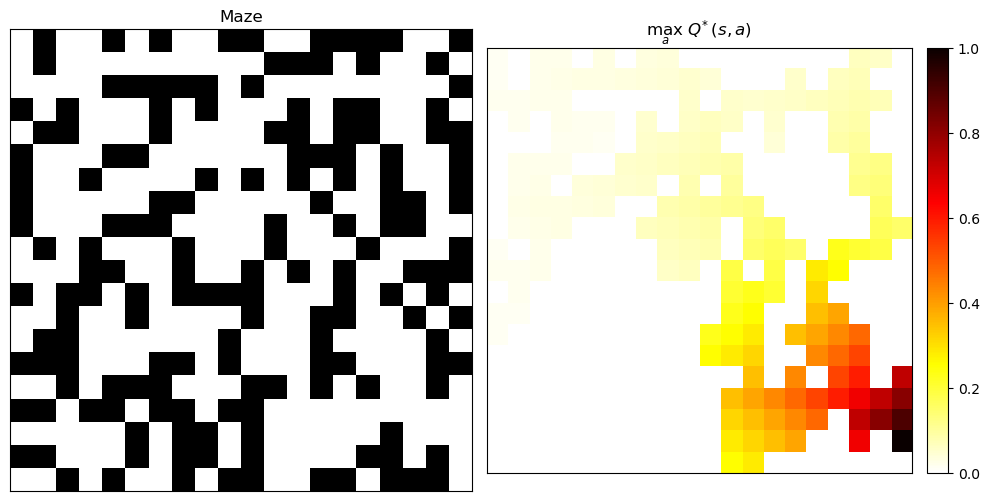

In [5]:
big_mdp, big_grid, big_q = get_maze_mdp(nrows=20, ncols=20, p=.4, gamma=.9, seed=SEED)
plot_maze_q_star(big_grid, big_q)

## Experiments

- Compare eps-greedy policy and softmax behaviour policy.
- Compare different values of the exploration parameters (epsilon for eps-greedy and tau for softmax).
- Compare different learning rates.
- Compare different sizes and difficluties of Maze MDPs.
- Check that your learned Q functions make sense.

### Epsilon-greedy vs softmax

In [6]:
ALPHA = .4
NB_ITER = int(1e6)

#### Epsilon-greedy

In [7]:
pol_eps = EpsGreedyPolicy(small_mdp, epsilon=0.3).get_action
q_eps, list_errors_eps, counts_eps = QLearning(small_mdp, pol_eps, small_q, alpha=ALPHA, nb_iter=NB_ITER)

Start Q learning with EpsGreedyPolicy


100%|██████████| 1000000/1000000 [00:19<00:00, 50994.16it/s]

Reached 33372 terminal states during learning


One episode: score = 1.0, time = 21


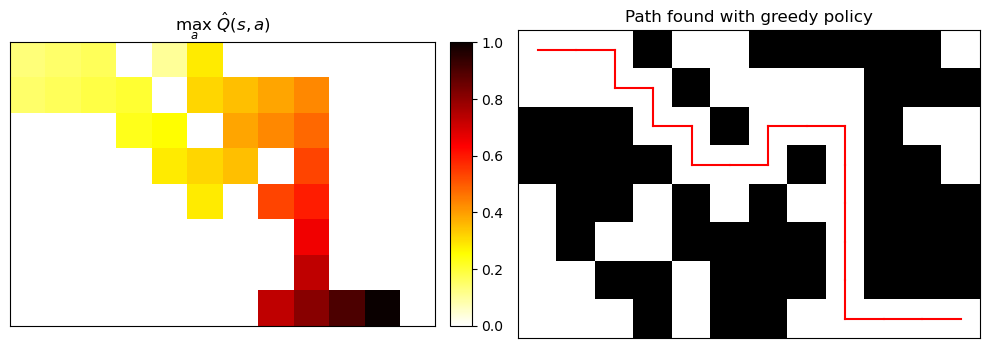

In [8]:
score, t, path_eps = get_one_episode(small_mdp, q_eps)
plot_path_q(path_eps, small_grid, q_eps)

#### Softmax

In [9]:
pol_soft = SoftmaxPolicy(small_mdp, tau=0.4).get_action
q_soft, list_errors_soft, counts_soft = QLearning(small_mdp, pol_soft, small_q, alpha=ALPHA, nb_iter=NB_ITER)

Start Q learning with SoftmaxPolicy


 34%|███▍      | 341616/1000000 [00:10<00:19, 32931.97it/s]

Converged after 341616 iterations
Reached 43 terminal states during learning


One episode: score = 1.0, time = 21


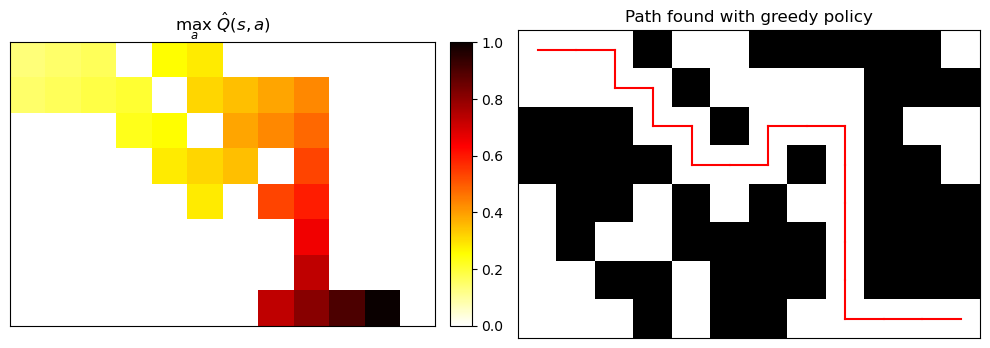

In [10]:
score, t, path_soft = get_one_episode(small_mdp, q_soft)
plot_path_q(path_soft, small_grid, q_soft)

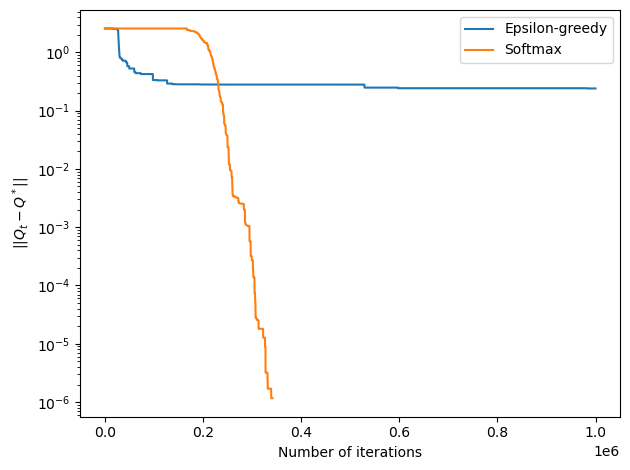

In [11]:
plot_errors({"Epsilon-greedy": list_errors_eps, "Softmax": list_errors_soft})
plt.tight_layout()

### On big maze

In [12]:
big_mdp.horizon = 10000

In [13]:
pol_eps = EpsGreedyPolicy(big_mdp, epsilon=.7).get_action
q_eps, list_errors_eps, counts_eps = QLearning(big_mdp, pol_eps, big_q, alpha=ALPHA, nb_iter=int(1e6))

Start Q learning with EpsGreedyPolicy


100%|██████████| 1000000/1000000 [00:23<00:00, 42664.96it/s]


Reached 5033 terminal states during learning


One episode: score = 1.0, time = 49


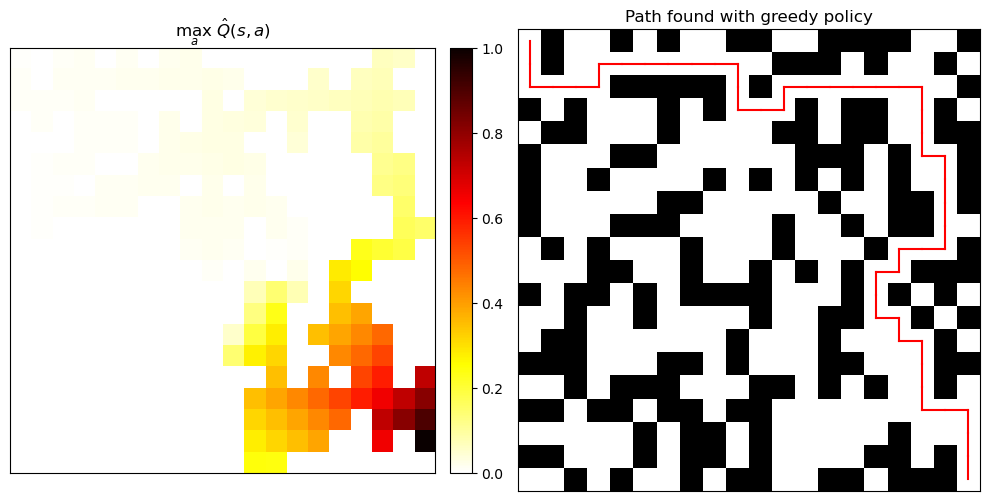

In [14]:
score, t, path_eps = get_one_episode(big_mdp, q_eps)
plot_path_q(path_eps, big_grid, q_eps)

In [15]:
pol_soft = SoftmaxPolicy(big_mdp, tau=0.4).get_action
q_soft, list_errors_soft, counts_soft = QLearning(big_mdp, pol_soft, big_q, alpha=ALPHA, nb_iter=int(1e6))

Start Q learning with SoftmaxPolicy


 37%|███▋      | 373466/1000000 [00:12<00:21, 29188.44it/s]

Converged after 373466 iterations
Reached 98 terminal states during learning


One episode: score = 1.0, time = 43


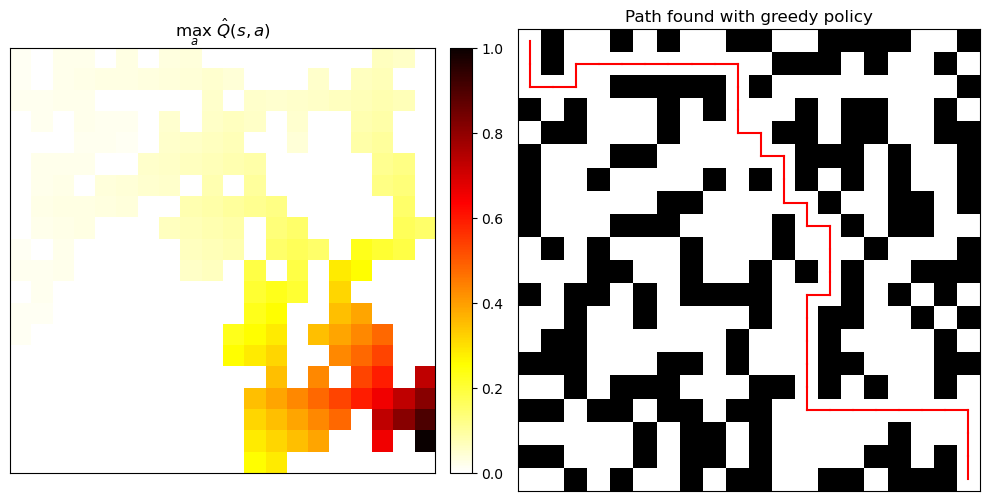

In [16]:
score, t, path_soft = get_one_episode(big_mdp, q_soft)
plot_path_q(path_soft, big_grid, q_soft)

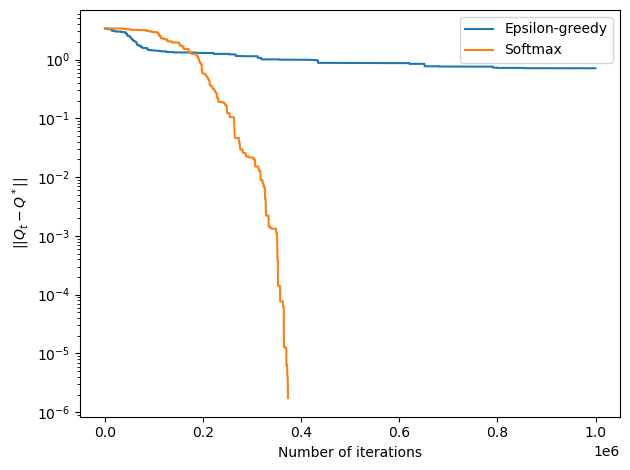

In [17]:
plot_errors({"Epsilon-greedy": list_errors_eps, "Softmax": list_errors_soft})
plt.tight_layout()